In [8]:
!pip install ucimlrepo
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
facebook_live_sellers_in_thailand = fetch_ucirepo(id=488) 
  
# data (as pandas dataframes) 
X = facebook_live_sellers_in_thailand.data.features 
y = facebook_live_sellers_in_thailand.data.targets 
  
# metadata 
print(facebook_live_sellers_in_thailand.metadata) 
  
# variable information 
print(facebook_live_sellers_in_thailand.variables) 


Defaulting to user installation because normal site-packages is not writeable
{'uci_id': 488, 'name': 'Facebook Live Sellers in Thailand', 'repository_url': 'https://archive.ics.uci.edu/dataset/488/facebook+live+sellers+in+thailand', 'data_url': 'https://archive.ics.uci.edu/static/public/488/data.csv', 'abstract': 'Facebook pages of 10 Thai fashion and cosmetics retail sellers. Posts of a different nature (video, photos, statuses, and links). Engagement metrics consist of comments, shares, and reactions.', 'area': 'Business', 'tasks': ['Clustering'], 'characteristics': ['Multivariate'], 'num_instances': 7051, 'num_features': 11, 'feature_types': ['Integer'], 'demographics': [], 'target_col': None, 'index_col': ['status_id'], 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2018, 'last_updated': 'Fri Mar 29 2024', 'dataset_doi': '10.24432/C5R60S', 'creators': ['Nassim Dehouche'], 'intro_paper': {'ID': 454, 'type': 'NATIVE', 'title': 'Dataset on usag

In [9]:
X.head()

,status_type,status_published,num_reactions,num_comments,num_shares,num_likes,num_loves,num_wows,num_hahas,num_sads,num_angrys
0,video,4/22/2018 6:00,529,512,262,432,92,3,1,1,0
1,photo,4/21/2018 22:45,150,0,0,150,0,0,0,0,0
2,video,4/21/2018 6:17,227,236,57,204,21,1,1,0,0
3,photo,4/21/2018 2:29,111,0,0,111,0,0,0,0,0
4,photo,4/18/2018 3:22,213,0,0,204,9,0,0,0,0


In [18]:
X.status_type.isnull().sum()

np.int64(0)

In [10]:
print(y)

None


In [11]:
# Clustering analysis: imports and preprocessing
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
from kneed import KneeLocator

# make a copy of X to work with (in case it's a DataFrame)
X_work = X.copy()

# If X is a DataFrame, drop non-numeric columns if any (safe-guard)
if isinstance(X_work, pd.DataFrame):
    X_num = X_work.select_dtypes(include=[np.number]).copy()
else:
    X_num = pd.DataFrame(X_work)

# Handle missing values (simple imputation with mean)
if X_num.isnull().any().any():
    X_num = X_num.fillna(X_num.mean())

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_num)


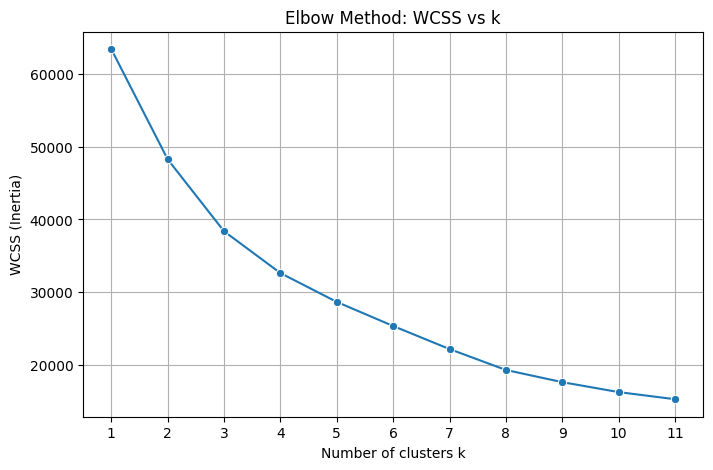

In [12]:
# Compute WCSS (inertia) for k=1..11
wcss = []
K_range = range(1, 12)  # 1..11
for k in K_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(X_scaled)
    wcss.append(km.inertia_)

# Plot elbow (WCSS vs k)
plt.figure(figsize=(8,5))
sns.lineplot(x=list(K_range), y=wcss, marker='o')
plt.xticks(list(K_range))
plt.xlabel('Number of clusters k')
plt.ylabel('WCSS (Inertia)')
plt.title('Elbow Method: WCSS vs k')
plt.grid(True)
plt.show()


In [13]:
# Use kneed to find the elbow between k=2..11
k_values = list(range(2, 12))
inertias_for_k = [wcss[k-1] for k in k_values]  # wcss list indexed from k=1 at pos0

# KneeLocator expects x and y arrays. We look for the knee in the inertia curve.
knee = KneeLocator(k_values, inertias_for_k, curve='convex', direction='decreasing')
k_opt = knee.knee
print(f'Kneedle found knee at k = {k_opt}')

# If k_opt is None (kneed couldn't find it), fall back to simple heuristic: the k with largest second derivative drop
if k_opt is None:
    # compute discrete second derivative (approx) and take argmax
    diffs = np.diff(inertias_for_k)
    second_diffs = np.diff(diffs)
    idx = np.argmax(-second_diffs)  # largest concavity
    k_opt = k_values[idx+1]  # offset due to diff lengths
    print(f'Fallback heuristic selected k = {k_opt}')

# Fit KMeans with optimal k (if valid) and compute silhouette score
if k_opt is not None and k_opt >= 2:
    km_opt = KMeans(n_clusters=k_opt, random_state=42, n_init=10)
    labels_opt = km_opt.fit_predict(X_scaled)
    sil_opt = silhouette_score(X_scaled, labels_opt)
    print(f'Silhouette score for k={k_opt}: {sil_opt:.4f}')
else:
    print('No valid optimal k found by kneed or fallback; skipping silhouette for optimal k')


Kneedle found knee at k = 5
Silhouette score for k=5: 0.7609
Silhouette score for k=5: 0.7609


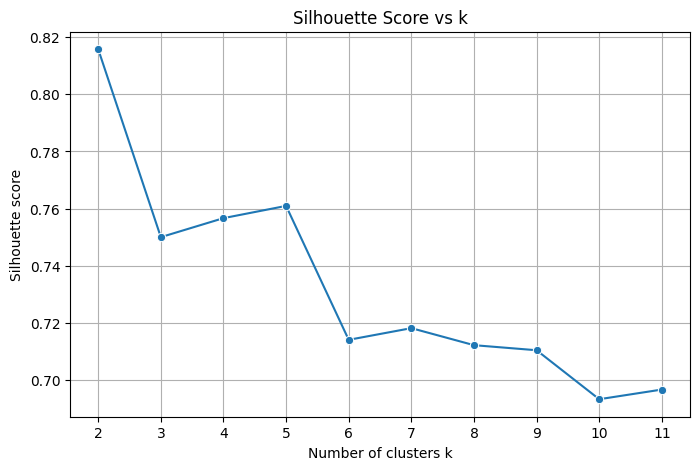

k -> silhouette score
2 -> 0.8157664963353164
3 -> 0.7499921477392748
4 -> 0.7566415831793409
5 -> 0.7609294896257128
6 -> 0.7140576613050015
7 -> 0.7181418523656731
8 -> 0.7121833991238358
9 -> 0.7104098182809936
10 -> 0.6932667670715073
11 -> 0.6966510920680359


In [14]:
# Compute silhouette scores for k=2..11 to compare
sil_scores = {}
for k in range(2, 12):
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X_scaled)
    try:
        s = silhouette_score(X_scaled, labels)
    except Exception as e:
        s = np.nan
    sil_scores[k] = s

# Plot silhouette scores
plt.figure(figsize=(8,5))
ks = list(sil_scores.keys())
vals = [sil_scores[k] for k in ks]
sns.lineplot(x=ks, y=vals, marker='o')
plt.xticks(ks)
plt.xlabel('Number of clusters k')
plt.ylabel('Silhouette score')
plt.title('Silhouette Score vs k')
plt.grid(True)
plt.show()

# Print table of silhouette scores
print('k -> silhouette score')
for k, s in sil_scores.items():
    print(f'{k} -> {s}')


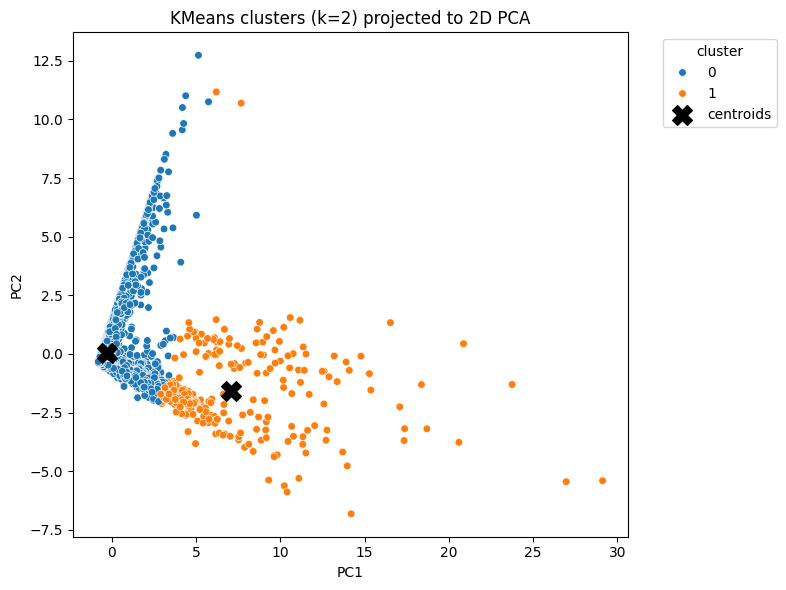

k=2 cluster sizes: 0:6776, 1:274
Centroids (original feature scale):
   num_reactions  num_comments  num_shares   num_likes   num_loves   num_wows  \
0     206.013725    104.041913   21.208973  197.605962    7.233471   0.646104   
1     826.193431   3199.715328  505.281022  646.262774  148.624088  17.197080   

   num_hahas  num_sads  num_angrys  
0   0.331169  0.142710    0.051505  
1   9.729927  2.740876    1.638686  




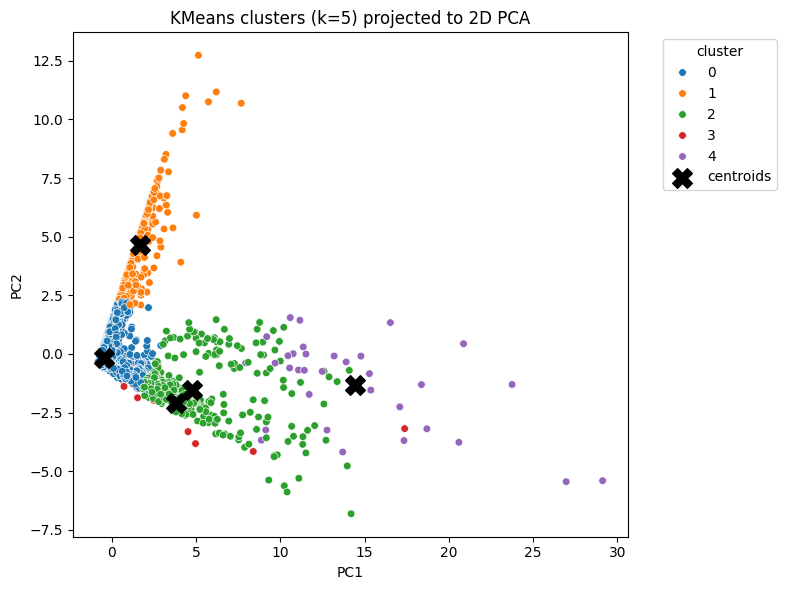

k=5 cluster sizes: 0:6262, 1:372, 2:366, 3:17, 4:33
Centroids (original feature scale):
   num_reactions  num_comments  num_shares    num_likes   num_loves  \
0     109.824976     74.464548   16.564037   102.863302    6.005110   
1    1823.311828     61.333333   11.645161  1817.534946    3.104839   
2     545.732240   2808.262295  405.508197   422.497268  111.010929   
3     403.294118    488.529412   51.588235   333.294118   37.058824   
4    1507.151515   1711.151515  751.818182  1075.787879  294.484848   

     num_wows  num_hahas   num_sads  num_angrys  
0    0.523315   0.287608   0.105717    0.037847  
1    2.435484   0.198925   0.032258    0.005376  
2    3.830601   5.562842   1.502732    1.311475  
3    4.823529   1.647059  25.294118    1.176471  
4  103.727273  29.424242   1.939394    1.787879  




In [16]:
# Scatter plots of clusters (2D PCA projection) and cluster summaries
from sklearn.decomposition import PCA

# prepare k values: always show k=2 and the elbow/kneed-selected k if available
k_list = [2]
try:
    k_opt_val = int(k_opt)
    if k_opt_val not in k_list:
        k_list.append(k_opt_val)
except Exception:
    k_opt_val = None

# Fit KMeans and store models/labels
kmeans_models = {}
labels_dict = {}
for k in k_list:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X_scaled)
    kmeans_models[k] = km
    labels_dict[k] = labels

# PCA to 2 dimensions for visualization
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

import matplotlib.pyplot as plt
import seaborn as sns

for k in k_list:
    plt.figure(figsize=(8,6))
    # scatter plot colored by cluster label
    sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=labels_dict[k], palette='tab10', s=30, legend='full')
    # compute centroids in PCA space
    centers_pca = pca.transform(kmeans_models[k].cluster_centers_)
    plt.scatter(centers_pca[:,0], centers_pca[:,1], c='black', s=200, marker='X', label='centroids')
    plt.title(f'KMeans clusters (k={k}) projected to 2D PCA')
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.legend(title='cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

    # print cluster sizes and centroids (inverse transform centroids to original feature scale)
    unique, counts = np.unique(labels_dict[k], return_counts=True)
    print(f'k={k} cluster sizes: ' + ', '.join([f'{int(u)}:{int(c)}' for u,c in zip(unique,counts)]))
    centers_orig = scaler.inverse_transform(kmeans_models[k].cluster_centers_)
    print('Centroids (original feature scale):')
    print(pd.DataFrame(centers_orig, columns=X_num.columns))
    print('\n')


In [20]:
# Compare clustering results with status_type
from sklearn.metrics import confusion_matrix
import pandas as pd

# Get status_type from original data
status_types = X['status_type']

# Function to print cluster composition
def analyze_clusters(labels, k, status_types):
    print(f"\nAnalysis for k={k} clusters:")
    # Create contingency table
    contingency = pd.crosstab(labels, status_types, margins=True)
    print("\nContingency table (clusters vs status_type):")
    print(contingency)
    
    # Calculate composition percentages within each cluster
    print("\nCluster composition (percentages):")
    composition = pd.crosstab(labels, status_types, normalize='index') * 100
    print(composition.round(2))
    
    # Print most common status_type for each cluster
    print("\nDominant status_type in each cluster:")
    for cluster in range(k):
        cluster_status = status_types[labels == cluster]
        most_common = cluster_status.mode()[0]
        percentage = (cluster_status == most_common).mean() * 100
        print(f"Cluster {cluster}: {most_common} ({percentage:.2f}%)")

# Analyze both k=2 and k=5 (or k_opt) results
for k in k_list:
    analyze_clusters(labels_dict[k], k, status_types)


Analysis for k=2 clusters:

Contingency table (clusters vs status_type):
status_type  link  photo  status  video   All
row_0                                        
0              63   4270     365   2078  6776
1               0     18       0    256   274
All            63   4288     365   2334  7050

Cluster composition (percentages):
status_type  link  photo  status  video
row_0                                  
0            0.93  63.02    5.39  30.67
1            0.00   6.57    0.00  93.43

Dominant status_type in each cluster:
Cluster 0: photo (63.02%)
Cluster 1: video (93.43%)

Analysis for k=5 clusters:

Contingency table (clusters vs status_type):
status_type  link  photo  status  video   All
row_0                                        
0              49   4048     295   1870  6262
1              14    212      70     76   372
2               0     13       0    353   366
3               0     14       0      3    17
4               0      1       0     32    33
All          

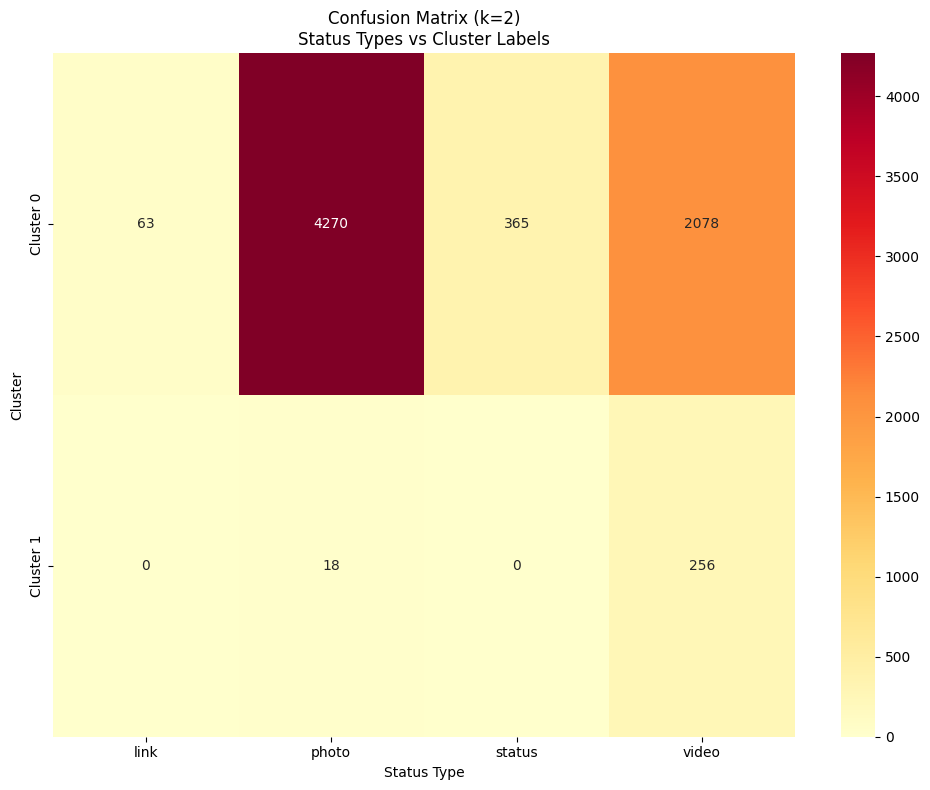


Percentage distribution within each status type (k=2):
status_type   link  photo  status  video
row_0                                   
0            100.0  99.58   100.0  89.03
1              0.0   0.42     0.0  10.97


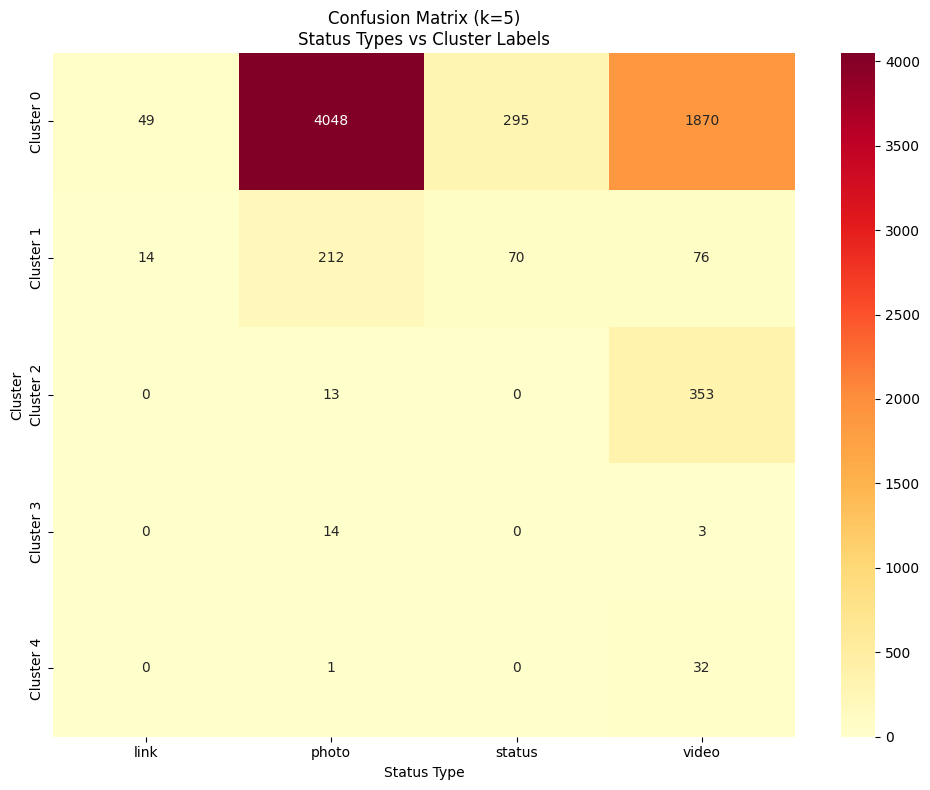


Percentage distribution within each status type (k=5):
status_type   link  photo  status  video
row_0                                   
0            77.78  94.40   80.82  80.12
1            22.22   4.94   19.18   3.26
2             0.00   0.30    0.00  15.12
3             0.00   0.33    0.00   0.13
4             0.00   0.02    0.00   1.37


In [22]:
# Visualize confusion matrices
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_matrix(labels, status_types, k):
    # Create confusion matrix as a DataFrame for better visualization
    conf_matrix = pd.crosstab(labels, status_types)
    
    # Create a figure with appropriate size
    plt.figure(figsize=(10, 8))
    
    # Create heatmap
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='YlOrRd',
                xticklabels=conf_matrix.columns,
                yticklabels=[f'Cluster {i}' for i in range(k)])
    
    plt.title(f'Confusion Matrix (k={k})\nStatus Types vs Cluster Labels')
    plt.xlabel('Status Type')
    plt.ylabel('Cluster')
    plt.tight_layout()
    plt.show()
    
    # Also show percentages within each status type
    print(f"\nPercentage distribution within each status type (k={k}):")
    percentage_matrix = pd.crosstab(labels, status_types, normalize='columns') * 100
    print(percentage_matrix.round(2))

# Plot confusion matrices for both k values
for k in k_list:
    plot_confusion_matrix(labels_dict[k], status_types, k)